#### Importing Required libraries for modeling and representation

In [1]:
# Import necessary libraries
from numpy import array
import pandas as pd
import numpy as np
from datetime import datetime
from numpy import asarray
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, KFold
import random
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import pickle
import csv
from dateutil.relativedelta import relativedelta

#### Reading historical data from multiple files and cleaning and formatting the data

In [2]:
# Read CPI data from CSV file
cpi_monthly_1950_1988 = pd.read_csv('input/cpi_data_Jan1950_Dec1988.csv')
cpi_monthly_1989_2023 = pd.read_csv('input/cpi_data_Jan1989_Oct2023.csv')
# Concat both the dataframes
cpi_data = pd.concat([cpi_monthly_1950_1988, cpi_monthly_1989_2023], axis=0)
cpi_data.tail()
# Extract Year and Month from 'Dates' column
cpi_data['Month'] = cpi_data['Dates'].str.split('-').str[0].astype('str')
cpi_data['Year'] = cpi_data['Dates'].str.split('-').str[1].astype('str')
# Create a new column 'FormattedDate' in the desired format
cpi_data['FormattedDate'] = pd.to_datetime(cpi_data['Month'] + ' ' + cpi_data['Year'], format='%b %y').dt.strftime('%m/%d/%Y %H:%M')
cpi_data['Dates'] = cpi_data['FormattedDate']
# Dropping temperary columns
cpi_data = cpi_data.drop(columns=['Year', 'Month', 'FormattedDate'], axis=1)
# Setting idex as Dates column
cpi_data.set_index('Dates', inplace=True)
cpi_data.tail()

,Dates,CPIH,CPI,Average CPIH
413,Jun-23,7.3,7.9,2.6
414,Jul-23,6.4,6.8,2.6
415,Aug-23,6.3,6.7,2.6
416,Sep-23,6.3,6.7,2.6
417,Oct-23,4.7,4.6,2.6


#### Bulding a model for CPI Prediction using LSTM time varient approach and training on historical data

In [5]:
# Scale data between 0 and 1
scaler = MinMaxScaler()
scaled_cpi = asarray(cpi_data['CPI']).reshape(-1, 1)
scaled_cpi = scaler.fit_transform(scaled_cpi)
# Omit the last 50 observations for out-of-sample forecast
out_of_sample_forecast_input = scaled_cpi[len(scaled_cpi) - 50:, 0]
scaled_cpi = scaled_cpi[:len(scaled_cpi) - 50, 0]

# let's transform our remaning data into a univariate supervised learning problem
# Functions transforms our time series sequence into a supervised leaning problem
# Transform data into a univariate supervised learning problem
def split_sequences(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence) - (n_steps_in + n_steps_out)):
        append_X = []
        append_y = []
        for j in range(n_steps_in):
            append_X.append(sequence[i + j])
        for k in range(n_steps_out):
            append_y.append(sequence[i + n_steps_in + k + 1])

        X.append(append_X)
        y.append(append_y)

    return np.array(X), np.array(y)

# Set the number of lags and forecast periods
n_steps_in = 50
n_steps_out = 12

# Create sequences for input (X) and output (y)
X, y = split_sequences(scaled_cpi, n_steps_in, n_steps_out)

# Split data into training and testing 80:20
total_rows = X.shape[0]
train_rows = int(total_rows * 0.8)
test_rows = total_rows - train_rows

# Obtain training and testing data
X_train = X[:train_rows]
X_test = X[train_rows:]
y_train = y[:train_rows]
y_test = y[train_rows:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(75, activation='relu', return_sequences=True, input_shape=(n_steps_in, 1)))
model.add(LSTM(75, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer='adam')
training_model = model.fit(X_train, y_train, epochs=50, verbose=1)

# Perform out-of-sample forecast
out_of_sample_forecast_input = asarray(out_of_sample_forecast_input).reshape(1, n_steps_in)
out_of_sample_forecast = model.predict(out_of_sample_forecast_input, verbose=0)

# Inversely scale the forecasted data and save it to a CSV file
list_forecast = scaler.inverse_transform(out_of_sample_forecast).tolist()
print('Predicted CPI Data for next 12 months: ', list_forecast[0])

# Inversely scale the forecasted data and save it to a CSV file
list_actual_50 = scaler.inverse_transform(out_of_sample_forecast_input).tolist()
print('Actual last 12 Months CPI data: ', list_actual_50[0][38:])

#### Preparing CPI data lists for represntation

In [8]:
# Creating list of data
latestdata = list_actual_50[0]
prediction = list_forecast[0]
prediction.insert(0, latestdata[-1])

#### Representing the last 50 monts and next 12 months predicted CPI data in yearly format.

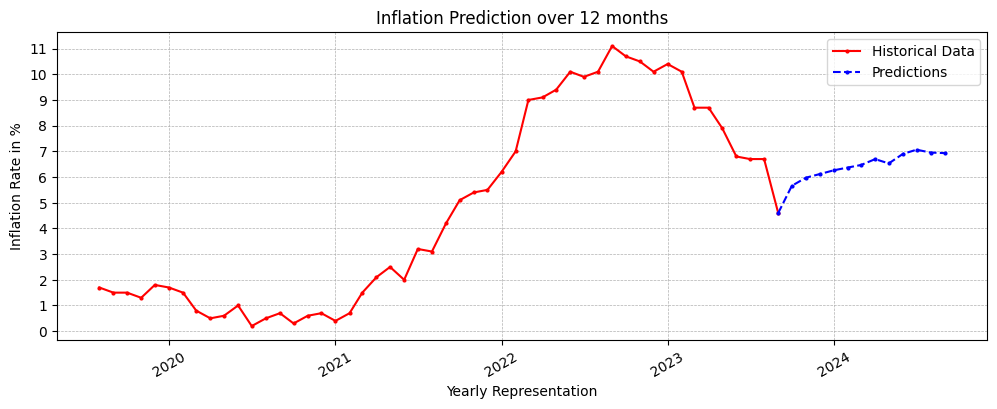

In [10]:
# Assuming 'latestdata' and 'prediction' are lists of corresponding values
month = 12
s = '08/2019'

# Generate date ranges for plotting
x1 = [datetime.strptime(s, '%m/%Y') + relativedelta(months=i) for i in range(50)]
x2 = [datetime.strptime(s, '%m/%Y') + relativedelta(months=49 + i) for i in range(month + 1)]

# Ensure that the lengths of x1 and x2 match the lengths of latestdata and prediction
x1 = x1[:len(latestdata)]
x2 = x2[:len(prediction)]

# Increase the width of the graph by setting the figsize parameter
plt.figure(figsize=(12, 4))  # Adjust the width (15 inches) and height (6 inches) as needed

# Plotting
plt.plot(x1, latestdata, 'r', label='Historical Data', marker='o', markersize=2)
plt.plot(x2, prediction, 'b--', label='Predictions', marker='o', markersize=2)
plt.xticks(rotation=30)
plt.yticks(range(12))  # Adjust Y axis values

# Add a blurred grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0, rasterized=True)
plt.title('Inflation Prediction over {} months'.format(month))
plt.xlabel('Yearly Representation')
plt.ylabel('Inflation Rate in %')
plt.legend()
plt.show()

#### Representing the last 50 monts and next 12 months predicted CPI data in querterly format.

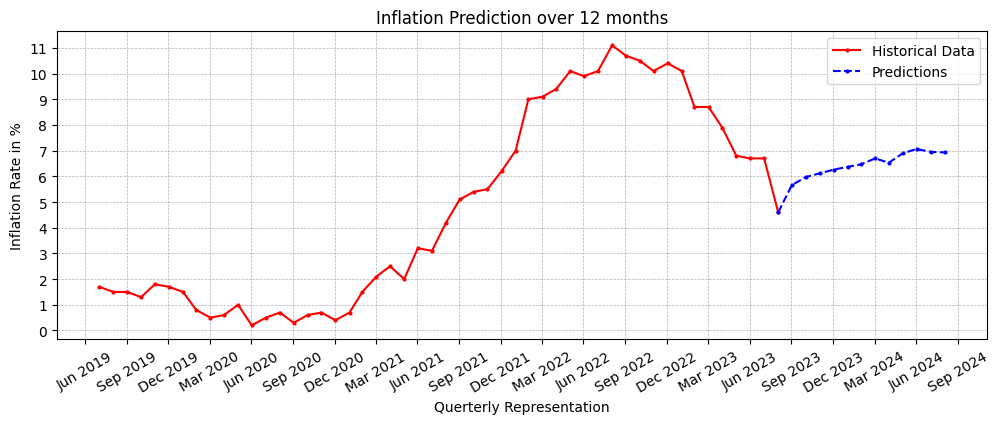

In [11]:
# Increase the width of the graph by setting the figsize parameter
plt.figure(figsize=(12, 4))  # Adjust the width (12 inches) and height (6 inches) as needed

# Plotting
plt.plot(x1, latestdata, 'r', label='Historical Data', marker='o', markersize=2)
plt.plot(x2, prediction, 'b--', label='Predictions', marker='o', markersize=2)

# Set x-axis ticks to display quarterly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=-1, interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=30)
plt.yticks(range(12))  # Adjust Y-axis values

# Add a blurred grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0, rasterized=True)
plt.title('Inflation Prediction over {} months'.format(month))
plt.xlabel('Querterly Representation')
plt.ylabel('Inflation Rate in %')
plt.legend()
plt.show()

#### Representing the last 50 monts and next 12 months predicted CPI data in monthly format.

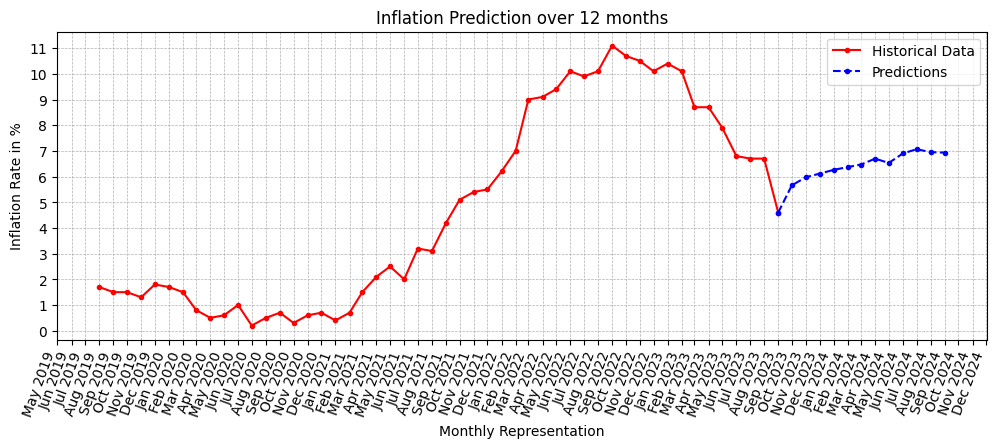

In [12]:
# Increase the width of the graph by setting the figsize parameter
plt.figure(figsize=(12, 4))  # Adjust the width (15 inches) and height (6 inches) as needed
# Plotting
plt.plot(x1, latestdata, 'r', label='Historical Data', marker='o', markersize=3)
plt.plot(x2, prediction, 'b--', label='Predictions', marker='o', markersize=3)
plt.xticks(rotation=70, ha="right")  # Adjust rotation for better readability
plt.yticks(range(12))  # Adjust Y axis values
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Set ticks at every month
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))  # Format tick labels
# Add a blurred grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0, rasterized=True)
plt.title('Inflation Prediction over {} months'.format(month))
plt.xlabel('Monthly Representation')
plt.ylabel('Inflation Rate in %')
plt.legend()
plt.show()